In [1]:
# Imports
%matplotlib notebook
import cvxpy as cp
import numpy as np
import pylgmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation
from pylgmath.so3.operations import vec2rot
import plotting
import sim
import local_solver
from sdp_relaxation import build_SDP_problem, block_diagonal
import mosek

In [2]:
# camera parameters
f_u = 100 # focal length in horizonal pixels
f_v = 100 # focal length in vertical pixels
c_u = 50 # pinhole projection in horizonal pixels
c_v = 50 # pinhold projection in vertical pixels
b = 0.2 # baseline (meters)

M = sim.make_stereo_camera_matrix(f_u, f_v, c_u, c_v, b)
R = 2 * np.eye(4) # covarience matrix for image-space noise


<IPython.core.display.Javascript object>


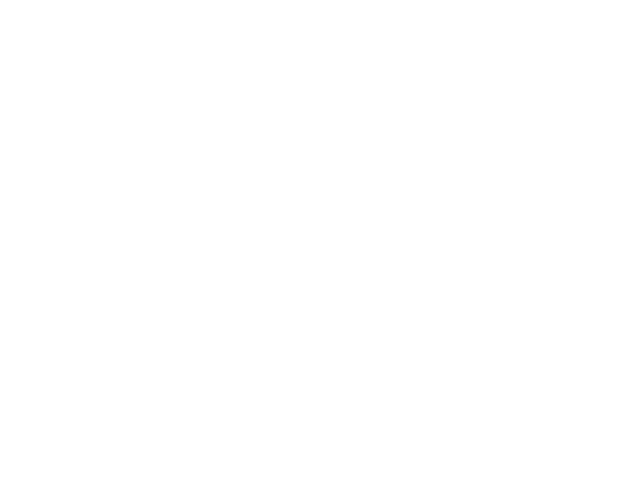

<IPython.core.display.Javascript object>


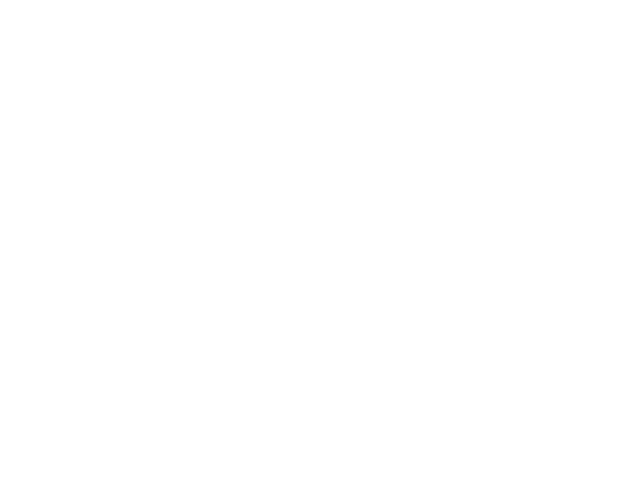

In [3]:
# make random camera pose
a = np.random.rand(3, 1)
theta = np.random.rand() * 2*np.pi
C_wc = vec2rot(theta * a/np.linalg.norm(a))
T_wc = np.eye(4)
T_wc[:3, :3] = C_wc
T_wc[:-1, -1] = [3*np.random.rand(), 3*np.random.rand(), 0]

# make sim instance w/ N points
N = 4
fig, ax, p_w, colors = sim.make_stereo_sim_instance(N, T_wc, np.array([[-1,1], [-1, 1], [2, 5]]))

# Generative camera model 
T_cw = np.linalg.inv(T_wc)
y = sim.generative_camera_model(M, T_cw, p_w)
dy = sim.generate_stereo_camera_noise(R, size = N)[:, :, None]
y = y + dy
camfig, (l_ax, r_ax) = sim.render_camera_points(y, colors)

## Stereo Localization Problem
$$\mathbf{T_{cw}} = \frac{1}{2} \text{argmin}_{\mathbf{T}} \sum_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)^T \mathbf{W}_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k),$$
$$\mathbf{T} \in SE(3),$$
$$z_k = \mathbf{a}^T \mathbf{T} \mathbf{p}_k,$$
$$\mathbf{a}^T = \begin{bmatrix}0 & 0 & 1 & 0\end{bmatrix}.$$


## Local Solver
Let $\mathbf{x} = \mathbf{T}\mathbf{p}_k$ so
$$\mathbf{u}_k(\mathbf{x}) = \mathbf{y}_k - \frac{1}{\mathbf{a}^T\mathbf{x}} \mathbf{M} \mathbf{x}.$$

We want to find a perturbation $\mathbf{\epsilon}^*$ so we can iterativly update our estimate $\mathbf{T}$:
$$\mathbf{T} \leftarrow \exp(\mathbf{\epsilon}^{*^{\wedge}}) \mathbf{T}_{op}.$$

Linear approximation of $\mathbf{u}_k(\mathbf{T} \mathbf{p}_k)$:

$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) = \mathbf{u}_k(\exp(\mathbf{\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx \mathbf{u}_k((\mathbf{1} + {\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx\mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) + \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot} \mathbf{\epsilon}$$
$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}$$

where
$$\mathbf{E}_k = (\frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k}(\mathbf{T}_{op}\mathbf{p}_k)^{\odot})^T \in \mathbb{R}^{6 \times 4},$$
$$\mathbf{b}_k = \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) \in \mathbb{R}^{4},$$
$$\frac{\partial \mathbf{u}(\mathbf{x})}{\partial \mathbf{x}} = \left(\frac{1}{\mathbf{a}^T \mathbf{x}}\right)^2 \mathbf{M} \mathbf{x} \mathbf{a}^T - \frac{1}{\mathbf{a}^T \mathbf{x}} \mathbf{M}.$$

Inserting this back into the cost function
$$\mathcal{L} = \frac{1}{2} \sum_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon})^T \mathbf{W}_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}),$$

and differentiating w.r.t $\mathbf{\epsilon}$ we obtain
$$\frac{\partial \mathcal{L}}{\partial \mathbf{\epsilon}} = \frac{1}{2} \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) (\mathbf{b}_k + \mathbf{E}_k^T \mathbf{\epsilon}).$$

Setting this to zero and rearranging, we find an expression that we can solve for $\mathbf{\epsilon}^*$:
$$\left(\sum_k (\mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) \mathbf{E}_k^T)\right) \mathbf{\epsilon^*} = - \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T)\mathbf{b}_k.$$


In [4]:
T_op = np.eye(4)
W = np.eye(4)

max_iters = 1000

T_op, local_minima = local_solver.stereo_localization_gauss_newton(T_op, y, p_w, W, M)

print("Estimate:\n", T_op)
print("Ground Truth:\n", T_cw)

Loss: 24288.502605923277
Loss: 3603.318947562748
Loss: 378.71340031091313
Loss: 232.26716971223698
Loss: 225.09249926843495
Loss: 214.26041290979185
Loss: 61.93410107701295
Loss: 32.70556237214558
Loss: 31.934405132252458
Loss: 31.933725602922834
Loss: 31.933725128301283
Loss: 31.933725127796983
Loss: 31.933725127796443
Loss: 31.93372512779642
Loss: 31.933725127796407
Estimate:
 [[ 0.37136275  0.40545669 -0.83528114 -0.77004475]
 [-0.03320878  0.9048391   0.42445656 -0.6088017 ]
 [ 0.92789379 -0.12988868  0.34948826 -0.83394957]
 [ 0.          0.          0.          1.        ]]
Ground Truth:
 [[ 0.33923706  0.42303043 -0.84021632 -0.62549228]
 [-0.03056157  0.89766584  0.43961578 -0.63082114]
 [ 0.94020434 -0.12345564  0.31744999 -0.78194961]
 [ 0.          0.          0.          1.        ]]


In [5]:
e_3 = np.zeros((4, 1))
e_3[2] = 1
v = (T_op @ p_w) / (e_3.T @ (T_op @ p_w))
assert np.isclose((np.eye(4,4) - v @ e_3.T) @ (T_op @ p_w), 0).all()

<IPython.core.display.Javascript object>


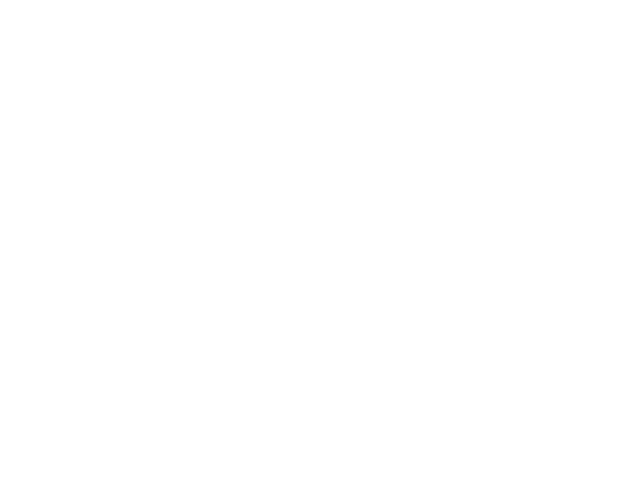

In [6]:
#visualize solution
plotting.add_coordinate_frame(np.linalg.inv(T_op), ax, "$\mathfrak{F}_{estimated}$")
fig

## SDP Relaxation Math

See `math.tex`


## From Stereo Localization to QCQP, and QCQP to SDP

We will define:
$$\mathbf{x} = \begin{bmatrix} \mathbf{c}_1 \\ \mathbf{c}_2 \\ \mathbf{c}_3 \\ \mathbf{r} \\ \mathbf{u}_1 \\ \dots \\ \mathbf{u}_n \\ \omega\end{bmatrix} \in \mathbb{R}^{13 + 3n}$$

In [7]:
# Fow now use the same W for each measurement
Ws = np.zeros((N, 4, 4))
for i in range(N):
    Ws[i] = W

In [8]:
# build x_local from local solution to test matricies

x_1 = T_op[:3, :].T.reshape((12, 1))
x_2 = (T_op @ p_w / np.expand_dims((np.array([0, 0, 1, 0]) @ T_op @ p_w), -1))[:, [0, 1, 3], :].reshape(-1, 1)
x = np.concatenate((x_1, x_2, np.array([[1]])), axis = 0)

### Cost Matrix

In [9]:
n = 13 + 3 * N
E = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
        [0, 0, 1]
    ]
)
e_3 = np.array([
    [0],
    [0],
    [1],
    [0]
])
Q = np.zeros((n, n))
Q[12:-1, 12:-1] = block_diagonal(E.T @ M.T @ Ws @ M @ E, k = 0)
g = -E.T @ M.T @ W @ y + E.T @ M.T @ Ws @ M @ e_3
Q[12:-1, -1] = g.reshape(-1)
Q[-1, 12:-1] = g.reshape(-1)
Omega = y.transpose((0, 2, 1)) @ Ws @ y - y.transpose((0, 2, 1)) @ Ws @ M @ e_3  - e_3.T @ M.T @ Ws @ y + e_3.T @ M.T @ Ws @ M @ e_3
Omega = Omega.sum()
Q[-1, -1] = Omega

In [10]:
print(x.T @ Q @ x, local_minima)
assert np.isclose(x.T @ Q @ x, local_minima)

[[31.93372513]] 31.933725127796407


### Rotation Matrix Constraints

In [11]:
As = []
bs = []

A = np.zeros((n, n))
A[0:3, 0:3] = np.eye(3)
As.append(A)
bs.append(1)

A = np.zeros((n, n))
A[3:6, 3:6] = np.eye(3)
As.append(A)
bs.append(1)

A = np.zeros((n, n))
A[6:9, 6:9] = np.eye(3)
As.append(A)
bs.append(1)

A = np.zeros((n, n))
A[0:3, 3:6] = np.eye(3)
A = 0.5 * (A + A.T)
As.append(A)
bs.append(0)

A = np.zeros((n, n))
A[0:3, 6:9] = np.eye(3)
A = 0.5 * (A + A.T)
As.append(A)
bs.append(0)


A = np.zeros((n, n))
A[3:6, 6:9] = np.eye(3)
A = 0.5 * (A + A.T)
As.append(A)
bs.append(0)

### Homogenization Variable Constraints

In [12]:
A = np.zeros((n, n))
A[-1, -1] = 1
As.append(A)
bs.append(1)

### Measurment Constraints

In [13]:
e_1 = np.zeros((3, 1))
e_1[0, 0] = 1

e_2 = np.zeros((3, 1))
e_2[1, 0] = 1

e_3 = np.zeros((3, 1))
e_3[2, 0] = 1

for k in range(N):
    A = np.zeros((n, n))
    e13 = e_1 @ e_3.T
    m = -np.expand_dims(e13, 0) * np.expand_dims(p_w[k], -1)
    m = m.transpose((1, 0, 2))
    m = m.reshape((3, -1))
    A[12 + 3*k : 12 + 3*k + 3, 0:12] = m
    A[-1, 0:12] = (e_1.T * np.expand_dims(p_w[k], -1)).flatten()
    A = 0.5 * (A + A.T)
    As.append(A)
    bs.append(0)
    
    A = np.zeros((n, n))
    e23 = e_2 @ e_3.T
    m = -np.expand_dims(e23, 0) * np.expand_dims(p_w[k], -1)
    m = m.transpose((1, 0, 2))
    m = m.reshape((3, -1))
    A[12 + 3*k : 12 + 3*k + 3, 0:12] = m
    A[-1, 0:12] = (e_2.T * np.expand_dims(p_w[k], -1)).flatten()
    A = 0.5 * (A + A.T)
    A = 0.5 * (A + A.T)
    As.append(A)
    bs.append(0)
    
    A = np.zeros((n, n))
    e33 = e_3 @ e_3.T
    m = np.expand_dims(e33, 0) * np.expand_dims(p_w[k], -1)
    m = m.transpose((1, 0, 2))
    m = m.reshape((3, -1))
    A[12 + 3*k : 12 + 3*k + 3, 0:12] = m
    A = 0.5 * (A + A.T)
    As.append(A)
    bs.append(1)


In [14]:
for A, b in zip(As, bs):
    print(x.T @ A @ x, b)
    assert np.isclose(x.T @ A @ x, b)

[[1.]] 1
[[1.]] 1
[[1.]] 1
[[0.]] 0
[[2.09901541e-16]] 0
[[-2.22044605e-16]] 0
[[1.]] 1
[[0.]] 0
[[5.55111512e-17]] 0
[[1.]] 1
[[-5.55111512e-17]] 0
[[5.55111512e-17]] 0
[[1.]] 1
[[0.]] 0
[[5.55111512e-17]] 0
[[1.]] 1
[[1.11022302e-16]] 0
[[-1.11022302e-16]] 0
[[1.]] 1


In [15]:
prob, X = build_SDP_problem(Q, As, bs)
prob.solve(solver=cp.MOSEK,)#mosek_params = {mosek.dparam.intpnt_co_tol_pfeas: 0.0})

# Print result.
print("The optimal value from the SDP is", prob.value)
print("The optimal value from the local solver is", local_minima)
#print("A solution X is")
X = X.value
print("SDP Solution rank:", np.linalg.matrix_rank(X))

The optimal value from the SDP is 3.1785392234298158
The optimal value from the local solver is 31.933725127796407
SDP Solution rank: 18


In [16]:
eig_values, eig_vectors = np.linalg.eig(X)

<IPython.core.display.Javascript object>


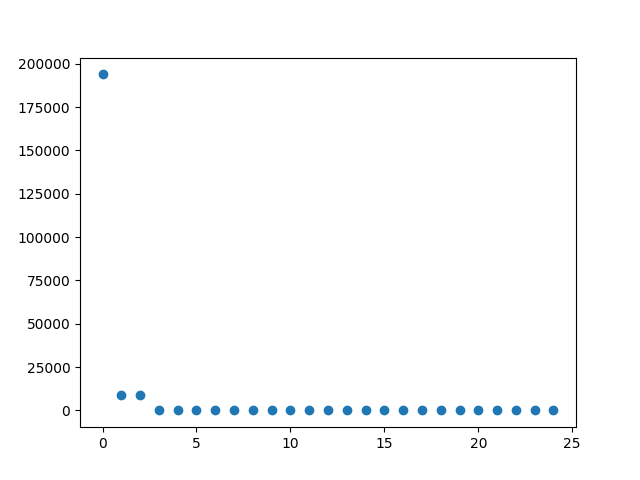

In [17]:
#ig_values = list(eig_values)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), eig_values)
plt.savefig("eigs.png")